In [1]:
import numpy as np
import pandas as pd 
from glob import glob
from os import path
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from torch.autograd import Variable
import torch.utils.data as utils
import tensorflow as tf
from datetime import datetime

c:\users\shaur\appdata\local\continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_file = r'data/train/train.csv'
test_path = r'data/test'
test_files = glob(path.join(test_path, '*.csv'))

In [3]:
def create_numpy_files(train_csv_file, output_folder):
    if path.exists(path.join(output_folder, 'train_acoustic_data.npy')):
        print('Numpy array exists, skipping')
        return
    
    train_df_chunked = pd.read_csv(train_csv_file, chunksize=10000000)
    acoustic_data_filepath = path.join(output_folder, 'train_acoustic_data')
    
    ttf_filepath = path.join(output_folder, 'train_time_to_failure')
    acoustic_data = list()
    time_to_failure = list()

    for chunk in train_df_chunked:
        a = chunk['acoustic_data'].values
        t = chunk['time_to_failure'].values
        acoustic_data.append(a.astype(np.int16))
        time_to_failure.append(t.astype(np.float32))
    
    acoustic_data = np.concatenate(acoustic_data)
    time_to_failure = np.concatenate(time_to_failure)
    np.save(acoustic_data_filepath, acoustic_data)
    np.save(ttf_filepath, time_to_failure)
        
    

In [4]:
create_numpy_files(train_csv_file=train_file, output_folder='data')

Numpy array exists, skipping


In [5]:
def load_train_data_from_numpy_files(folder):
    acoustic_data = np.load(path.join(folder, 'train_acoustic_data.npy'))
    time_to_failure = np.load(path.join(folder, 'train_time_to_failure.npy'))
    return acoustic_data, time_to_failure

In [6]:
acoustic_data, time_to_failure = load_train_data_from_numpy_files('data')

In [7]:
acoustic_data = np.expand_dims(acoustic_data, axis=1)
time_to_failure = np.expand_dims(time_to_failure, axis=1)

In [8]:
SEGMENT_SIZE = 150000
step_size = 5000

In [9]:
ends_mask = np.less(time_to_failure[:-1], time_to_failure[1:])
segment_ends = np.nonzero(ends_mask)[0]

In [10]:
del ends_mask

In [11]:
segments = list()
start = 0
for e in segment_ends:
    segments.append((start, e))
    start = e


In [12]:
segments_split_idx = int(0.8*len(segments))

In [13]:
train_segments = segments[:segments_split_idx]
test_segments = segments[segments_split_idx:]

In [14]:
scaler = preprocessing.StandardScaler(copy=False)

In [15]:
for se in train_segments:
    start = se[0]
    end = se[1]
    scaler.partial_fit(acoustic_data[start:end])

c:\users\shaur\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
class LANLRandomDataset(Dataset):
    def __init__(self, X, y, segments, step_size, steps_per_epoch, segment_size=SEGMENT_SIZE, scaler=None):
        self.X = X 
        self.y = y 
        self.segments = segments 
        self.num_segments = len(segments)
        self.segment_idx = 0
        self.step_size = step_size 
        self.segment_size = segment_size
        self.steps_per_epoch = steps_per_epoch
        self.scaler = scaler        
        
    def __len__(self):
        return self.steps_per_epoch
    
    def __getitem__(self, index):
        segment_idx = np.random.randint(self.num_segments)
        start, end = self.segments[segment_idx]
        start += self.segment_size
        
        end_offset = np.random.randint(start, end)
        x = self.X[end_offset - self.segment_size : end_offset].astype(np.float32)
        y = self.y[end_offset]
        if scaler is not None:
            x = self.scaler.transform(x, copy=True)
            
        return x, y

In [17]:
class LANLSequentialDataset(Dataset):
    def __init__(self, X, y, segments, step_size, segment_size=SEGMENT_SIZE, scaler=None):
        self.X = X 
        self.y = y 
        self.segments = segments 
        self.segment_idx = 0
        self.step_size = step_size 
        self.segment_size = segment_size
        self.scaler = scaler        
        self._calculate_len()
        self._assign_iterator()

        
    def _calculate_len(self):   
        self.len = 0
        for s in self.segments:
            start = s[0]
            end = s[1]
            assert(end > start + self.segment_size)
            L = len(range(start + self.segment_size, end, self.step_size)) + 1            
            self.len += L
            
    def _assign_iterator(self):
        idx = (self.segment_idx + 1) % len(self.segments)
        start = self.segments[idx][0] + self.segment_size
        end = self.segments[idx][1]
        self.range = range(start, end, self.step_size)
        self.iterator = iter(self.range)
        
            
    def __len__(self):
        return self.len        
    
    def __getitem__(self, idx):
        try:
            end_offset = next(self.iterator)            
        except StopIteration:
            end_offset = self.range.stop                                        
            self._assign_iterator()
                
        start_offset = end_offset - self.segment_size            
            
        data = self.X[start_offset:end_offset].astype(np.float32)        
        targets = self.y[end_offset]
        if self.scaler is not None:
            data = self.scaler.transform(data)
        
        return data, targets
            
        
            
            
            
        
        

In [22]:
batch_size=32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def test_lanl_dataset(acoustic_data, time_to_failure, segments):    
    dataset = LANLDataset(acoustic_data, time_to_failure, segments, 
                           step_size=step_size, segment_size=SEGMENT_SIZE)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

    it = dataloader.__iter__()
    for ii,segment in enumerate(segments_):
        start = segment[0]
        end = segment[1]
        stop = False
        for j in range(start, end, step_size):
            xx = acoustic_data[j:j+SEGMENT_SIZE]      
            yy = time_to_failure[j+SEGMENT_SIZE]

            try:
                aa, bb = next(it)
            except StopIteration:
                print('STOP ITERATION ', ii, j)
            if j + SEGMENT_SIZE >= end:
                xx = acoustic_data[end - SEGMENT_SIZE:end]
                yy = time_to_failure[end]
                stop=True

            error = np.sum(xx-aa.numpy()[0])
            if error != 0.0:
                print('ERROR ', j, error)

            if stop:
                break
    try:
        next(it)
    except StopIteration:
        print('done')
        

    
    
    

In [20]:
# test_lanl_dataset(acoustic_data, time_to_failure, segments)

In [21]:
# train_segments = [segments[0]]

In [22]:
lanl_train_dataset = LANLRandomDataset(acoustic_data, time_to_failure, train_segments,
                                       steps_per_epoch=30000,
                           step_size=step_size, segment_size=SEGMENT_SIZE, scaler=scaler)

train_dataloader = torch.utils.data.DataLoader(lanl_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [23]:
len(lanl_train_dataset)

30000

In [23]:
class LANLModel(nn.Module):
    def __init__(self, batch_size, segment_size=SEGMENT_SIZE):
        super(LANLModel, self).__init__()
        self.batch_size = batch_size
        self.segment_size = segment_size
        self.conv1 = nn.Conv1d(1,16,kernel_size=10,stride=10)
        self.pool1 = nn.MaxPool1d(10)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(self.conv1.out_channels, 32, kernel_size=5, stride=5)
        self.pool2 = nn.MaxPool1d(3)
        self.conv3 = nn.Conv1d(self.conv2.out_channels, 64, kernel_size=5, stride=5)
        self.lstm = nn.LSTM(input_size=600, hidden_size=64, num_layers=2, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(128, 1)
        
    def forward(self, x):
        x = x.transpose(-1,-2)
        x = self.conv1(x)
        x = self.relu(x)
#         x = self.pool1(x)        
        x = self.conv2(x)
        x = self.relu(x)
#         x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        
        x,_ = self.lstm(x)
        
        x = self.linear(x[:,-1])
        return x
        

In [26]:
learning_rate = 1e-3
model = LANLModel(batch_size=batch_size)
loss_fn = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
count_parameters(model)

453521

In [44]:
if torch.cuda.is_available():
    model.cuda()
    
    
utcnow = datetime.utcnow().strftime("%Y-%m-%d-%H-%M")
model_checkpoint_path = f'model_checkpoints/checkpoint-{utcnow}.pt'

In [45]:
model_checkpoint_path

'model_checkpoints/checkpoint-2019-06-03-12-40.pt'

In [46]:
num_epochs = 20

optimizer.zero_grad()
for e in range(num_epochs):
    losses = []
    for ii,(batch_data, batch_label) in enumerate(train_dataloader):    
        batch_data, batch_label = batch_data.to(device), batch_label.to(device)                
        y_pred = model(batch_data)        
        loss = loss_fn(y_pred, batch_label)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (ii%100) == 0:
            print(np.mean(losses))
            losses = []
            
    torch.save({'epoch':e,
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': loss,}, model_checkpoint_path)
    print(f'Epoch {e} done')
        



1.6007838249206543
1.9856466114521027
2.018285574913025
1.9803051090240478
2.023714463710785
2.0219340038299563
2.040226318836212
1.98789369225502
2.0461009442806244
2.0265032017230986
Epoch 0 done
2.111517906188965
2.0276442086696624
2.054624274969101
2.024725775718689
1.9914623880386353
1.997474000453949
2.005046702623367
1.9523592865467072
2.036223530769348
2.069983934164047
Epoch 1 done
2.367745876312256
2.003069508075714
1.963439680337906
2.0240088403224945
2.0327306425571443
1.9671483826637268
2.038398251533508
1.9438027739524841
2.0345059037208557
2.075696907043457
Epoch 2 done
1.9097683429718018


KeyboardInterrupt: 

In [24]:
model_path = glob('model_checkpoints/*.pt')[-1]


In [25]:
checkpoint = torch.load(model_path)
model = LANLModel(batch_size=batch_size)
model.load_state_dict(checkpoint['model_state_dict'])
if torch.cuda.is_available():
    model.cuda()


In [26]:
lanl_test_dataset = LANLSequentialDataset(acoustic_data, time_to_failure, test_segments, 
                           step_size=step_size, segment_size=SEGMENT_SIZE, scaler=scaler)

test_dataloader = torch.utils.data.DataLoader(lanl_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [28]:
preds_ = []
ground_truth_ = []
with torch.no_grad():
    for (batch_data, batch_label) in test_dataloader:
        batch_data, batch_label = batch_data.to(device), batch_label.to(device)
        y_pred = model(batch_data)
        preds_.append(y_pred.cpu().numpy())
        ground_truth_.append(batch_label.cpu().numpy())

KeyboardInterrupt: 

In [62]:
ground_truth = np.concatenate(ground_truth_).ravel()
preds =  np.concatenate(preds_).ravel()

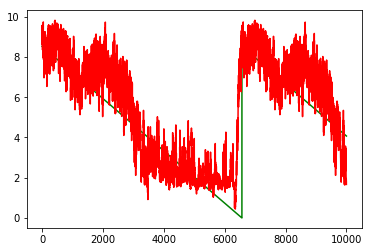

In [63]:
plt.plot(range(10000), ground_truth[:10000], 'g', preds[:10000], 'r')

In [35]:
submission_preds = {'seg_id':list(), 'time_to_failure':list()}
for test_file in test_files:
    file_id = path.splitext(path.basename(test_file))[0]
    
    df = pd.read_csv(test_file)
    acoustic_data = df['acoustic_data'].values.astype(np.float32)
    
    acoustic_data = acoustic_data[:,np.newaxis]
    acoustic_data = scaler.transform(acoustic_data, copy=True)
    acoustic_data = acoustic_data[np.newaxis,:]
    acoustic_data_tensor = torch.from_numpy(acoustic_data).to(device)    
    with torch.no_grad():
        y_pred = torch.squeeze(model(acoustic_data_tensor), -1)
        y_pred_npy = y_pred.cpu().numpy()
        submission_preds['seg_id'].append(file_id)
        submission_preds['time_to_failure'].append(y_pred_npy[0])
        

        

In [37]:
submission_df = pd.DataFrame.from_dict(submission_preds)

In [40]:
submission_df.to_csv('submission.csv', index=False)

In [86]:
submission_df.columns = 

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements